In [2]:
import numpy as np # linear algebra
import pandas as pd
import os
import keras.utils
from imageio import imread
import PIL
from skimage.transform import resize
from skimage import color
from matplotlib import pyplot as plt
# Any results you write to the current directory are saved as output.
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Convolution2D,BatchNormalization,Flatten,Dense,Dropout,MaxPool2D
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dirList=os.listdir('/content/drive/MyDrive/flowers')
imageData=[]
imageLabel=[]
validExtensionsList=['jpg','tif','png','bmp']
for d in dirList:
   print('Processing...',d)
   for f in os.listdir('/content/drive/MyDrive/flowers/'+d):
        ext=f.split('.')[-1]
        if ext in validExtensionsList:
            data=imread('/content/drive/MyDrive/flowers/'+d+'/'+f)
            #color.rgb2gray(imread('../input/flowers/flowers/'+d+'/'+f))
            resized_data=resize(data,(100,100))
            imageData.append(resized_data)
            imageLabel.append(d)
        else:
            pass
print('DONE!')

Processing... rose
Processing... dandelion
Processing... tulip
Processing... daisy
Processing... sunflower
DONE!


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
np.shape(imageData),np.shape(imageLabel)

((4317, 100, 100, 3), (4317,))

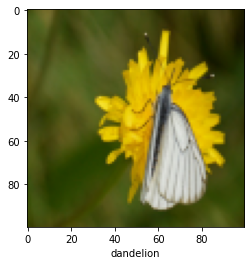

In [ ]:
idx=np.random.randint(len(imageData))
plt.imshow(imageData[idx])
plt.xlabel(imageLabel[idx])
plt.show()

In [6]:
X=np.array(imageData)
X=X.reshape(X.shape[0],X.shape[1],X.shape[2],3)
y=np.array(imageLabel)
num_classes=len(set(y))
le=LabelEncoder()
y=le.fit_transform(y)
y=to_categorical(num_classes=num_classes,y=y)
input_shape=(X.shape[1],X.shape[2],X.shape[3])

In [7]:
np.shape(X),np.shape(y)

((4317, 100, 100, 3), (4317, 5))

In [7]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(64,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(64,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Convolution2D(128,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(128,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Convolution2D(256,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(256,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Convolution2D(512,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(512,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Flatten())
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(num_classes,activation='softmax'))
    return model
model=createCNNModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       7

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test),np.shape(X_val),np.shape(y_val)

((2762, 100, 100, 3),
 (2762, 5),
 (864, 100, 100, 3),
 (864, 5),
 (691, 100, 100, 3),
 (691, 5))

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        #zoom_range = 0.1, # Randomly zoom image 
       # width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
       # height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)
datagen.fit(X_train)

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['acc'])

In [13]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 64) ,epochs = 100 , validation_data = datagen.flow(X_val,y_val))

Epoch 1/100
44/44 [==============================] - 12s 232ms/step - loss: 0.3358 - acc: 0.8794 - val_loss: 0.5799 - val_acc: 0.7887
Epoch 2/100
44/44 [==============================] - 10s 225ms/step - loss: 0.3008 - acc: 0.8899 - val_loss: 0.6078 - val_acc: 0.8177
Epoch 3/100
44/44 [==============================] - 10s 226ms/step - loss: 0.3091 - acc: 0.8888 - val_loss: 0.6254 - val_acc: 0.8017
Epoch 4/100
44/44 [==============================] - 10s 226ms/step - loss: 0.3133 - acc: 0.8845 - val_loss: 0.6152 - val_acc: 0.8017
Epoch 5/100
44/44 [==============================] - 10s 226ms/step - loss: 0.2956 - acc: 0.8874 - val_loss: 0.6293 - val_acc: 0.8090
Epoch 6/100
44/44 [==============================] - 10s 228ms/step - loss: 0.2776 - acc: 0.8993 - val_loss: 0.5852 - val_acc: 0.8119
Epoch 7/100
44/44 [==============================] - 10s 230ms/step - loss: 0.2794 - acc: 0.8957 - val_loss: 0.7888 - val_acc: 0.7323
Epoch 8/100
44/44 [==============================] - 10s 230ms

In [ ]:
hist=model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=64,epochs=50)

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

27/27 [==============================] - 1s 40ms/step - loss: 2.2926 - acc: 0.6400

Test Accuracy: 0.6400462985038757

Test Loss: 2.292602062225342


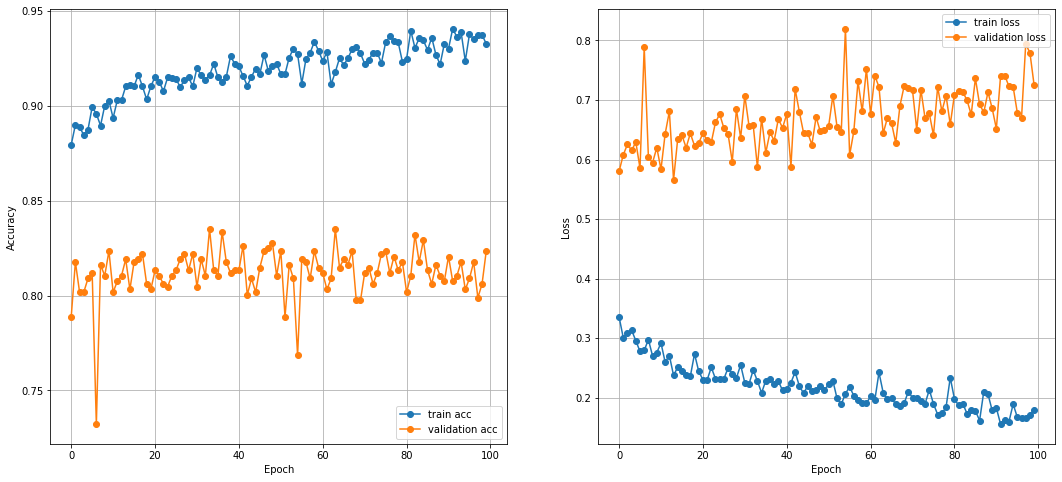

In [26]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], 'o-', label='train acc')
plt.plot(history.history['val_acc'], 'o-', label = 'validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()